In [ ]:
# ===================================================================
# HISTORICAL HEDONIC REGRESSION FOR PROPERTY VALUATION
# Inspired by Rosen (1974)
# ===================================================================

# Step 1: Import Required Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.datasets import fetch_openml
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')
print("Libraries imported successfully!")


Libraries imported successfully!


In [ ]:
# -------------------------------------------------------------------
# Step 2: Load Boston Housing Dataset
# -------------------------------------------------------------------
boston = fetch_openml(name='boston', version=1, parser='auto')
df = pd.DataFrame(boston.data, columns=boston.feature_names)
df['PRICE'] = boston.target
print(f"Dataset Shape: {df.shape}")
df.head()


Dataset Shape: (506, 14)


,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,PRICE
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222.0,18.7,396.90,5.33,36.2


## **Understanding the Dataset**

The **California Housing Dataset** contains:
- **20,640 observations** (census block groups)
- **8 features** describing property and neighborhood characteristics
- **Target variable:** Median house value (in $100,000s)

**Features we're using:**
- `MedInc` - Median income of households ($10,000s)
- `HouseAge` - Median age of houses (years)
- `AveRooms` - Average number of rooms per household
- `AveBedrms` - Average number of bedrooms per household
- `Population` - Block group population

**Why these features?**
These represent the types of characteristics that were **available in 1970s property records** - physical attributes, age, and demographic data.


## **The Heterogeneity Problem**

Notice how each property differs:
- Different sizes (rooms, bedrooms)
- Different ages
- Different neighborhood income levels

**Question:** How do we compare these "apples and oranges"?

**Answer:** Hedonic pricing decomposes the total price into the value of each individual characteristic! 🎯


=== Summary Statistics ===
             CRIM          ZN       INDUS         NOX          RM         AGE  \
count  506.000000  506.000000  506.000000  506.000000  506.000000  506.000000   
mean     3.613524   11.363636   11.136779    0.554695    6.284634   68.574901   
std      8.601545   23.322453    6.860353    0.115878    0.702617   28.148861   
min      0.006320    0.000000    0.460000    0.385000    3.561000    2.900000   
25%      0.082045    0.000000    5.190000    0.449000    5.885500   45.025000   
50%      0.256510    0.000000    9.690000    0.538000    6.208500   77.500000   
75%      3.677083   12.500000   18.100000    0.624000    6.623500   94.075000   
max     88.976200  100.000000   27.740000    0.871000    8.780000  100.000000   

              DIS         TAX     PTRATIO           B       LSTAT       PRICE  
count  506.000000  506.000000  506.000000  506.000000  506.000000  506.000000  
mean     3.795043  408.237154   18.455534  356.674032   12.653063   22.532806  
st

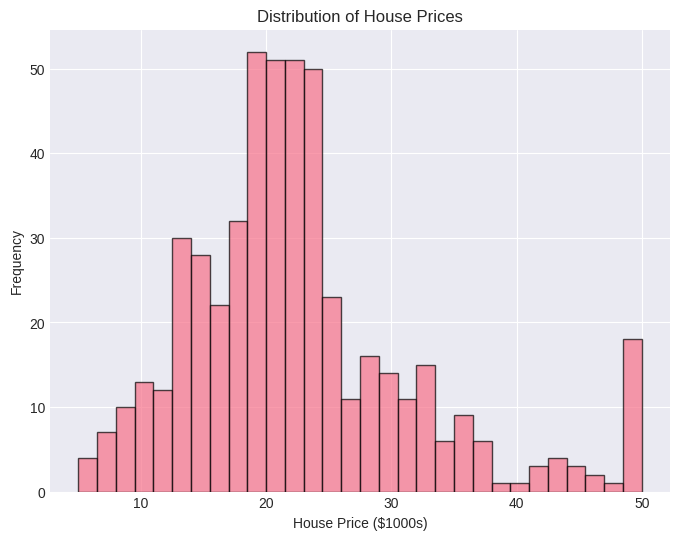

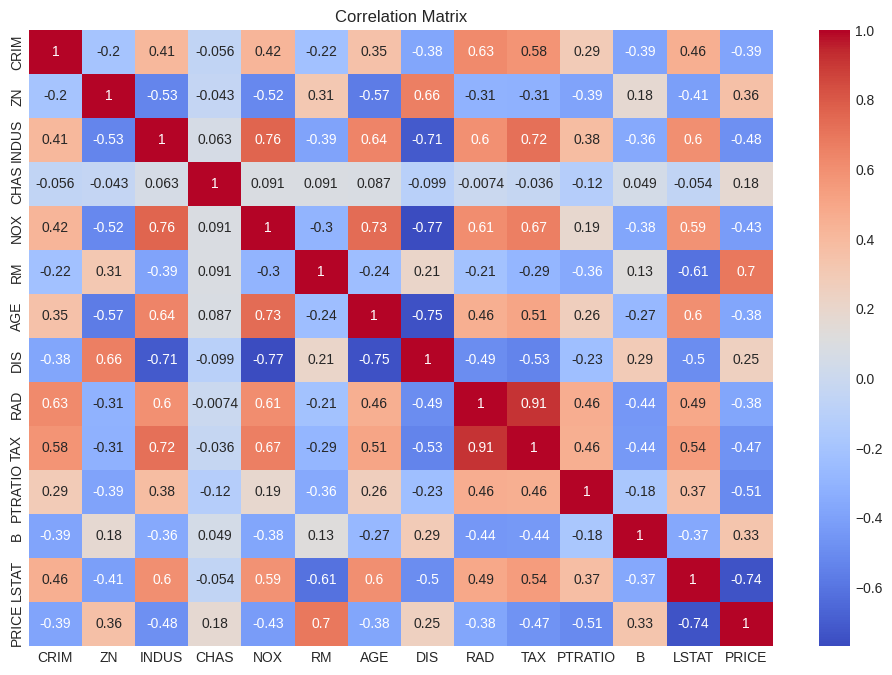

In [ ]:
# -------------------------------------------------------------------
# Step 3: Exploratory Data Analysis
# -------------------------------------------------------------------
print("\n=== Summary Statistics ===")
print(df.describe())

print("\n=== Missing Values ===")
print(df.isnull().sum())

# -------------------------------------------------------------------
# Step 4: Visualize Price Distribution
# -------------------------------------------------------------------
plt.figure(figsize=(8,6))
plt.hist(df['PRICE'], bins=30, edgecolor='black', alpha=0.7)
plt.xlabel('House Price ($1000s)')
plt.ylabel('Frequency')
plt.title('Distribution of House Prices')
plt.show()

# -------------------------------------------------------------------
# Step 5: Correlation Analysis
# -------------------------------------------------------------------
plt.figure(figsize=(12,8))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

In [ ]:
# -------------------------------------------------------------------
# Step 6: Splitting Dataset
# -------------------------------------------------------------------
X = df.drop('PRICE', axis=1)
y = df['PRICE']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(f"Training set size: {X_train.shape[0]}")
print(f"Testing set size: {X_test.shape[0]}")

Training set size: 404
Testing set size: 102



## **Model Training - The 1974 Approach**

### **Method: Ordinary Least Squares (OLS)**

This is the **exact method** used by Rosen (1974) and economists in the 1970s.

**What OLS does:**
Finds the coefficients (β values) that **minimize the sum of squared errors**:
```
Minimize: Σ(Actual Price - Predicted Price)²
```

**Mathematical Solution:**
```
β̂ = (X'X)⁻¹X'y
```

This was computationally challenging in the 1970s (required mainframe computers!), but is instant today.


## **Train-Test Split Concept**

- **Training Set (80%):** Model learns the relationships between features and prices
- **Test Set (20%):** We evaluate how well the model predicts prices for properties it has never seen

This simulates real-world use: Can the model value new properties accurately?

In [ ]:
# -------------------------------------------------------------------
# Step 7: Train the Hedonic Regression Model
# -------------------------------------------------------------------
model = LinearRegression()
model.fit(X_train, y_train)
print("\nHedonic Regression model trained successfully!")
print("Intercept:", round(model.intercept_, 3))


Hedonic Regression model trained successfully!
Intercept: 30.247



## **Implicit Prices - The Heart of Hedonic Analysis**

### **What Are Implicit Prices?**

Each coefficient (β) represents the **marginal willingness to pay** for one additional unit of that characteristic, holding all else constant.

**Economic Interpretation:**

If `MedInc` coefficient = 4.00, this means:
>"For every \$10,000 increase in median income of the area, the median house value increases by \$400,000 (4.00 × \$100,000)"


### **Positive vs Negative Coefficients**

- **Positive coefficient** → Feature increases property value
  - Example: More rooms → Higher price
  
- **Negative coefficient** → Feature decreases property value
  - Example: Higher pollution → Lower price


### **Why This Matters**

These implicit prices reveal:
1. **Market preferences** - What buyers value most
2. **Policy impact** - How school quality, crime, pollution affect values
3. **Investment decisions** - Which renovations add most value

In 1974, this was groundbreaking! It quantified what appraisers knew intuitively.


=== Hedonic Coefficients (Implicit Prices) ===
Feature  Coefficient
    NOX   -17.202633
     RM     4.438835
   CHAS     2.784438
    DIS    -1.447865
PTRATIO    -0.915456
  LSTAT    -0.508571
    RAD     0.262430
   CRIM    -0.113056
  INDUS     0.040381
     ZN     0.030110
      B     0.012351
    TAX    -0.010647
    AGE    -0.006296


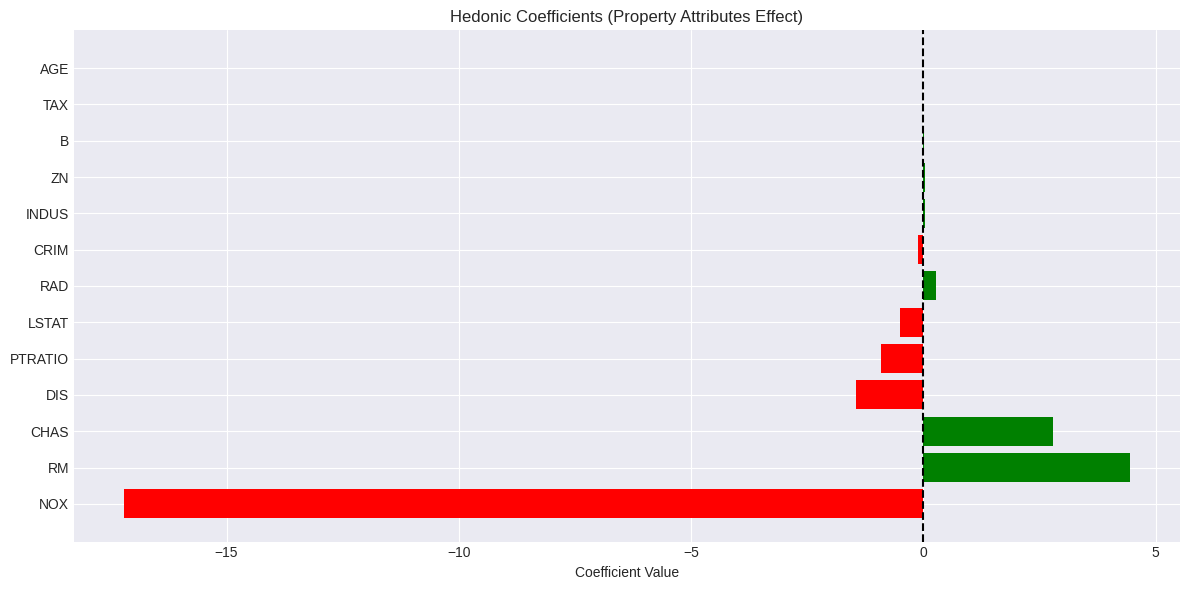

In [ ]:
# -------------------------------------------------------------------
# Step 8: Analyze Model Coefficients (Implicit Prices)
# -------------------------------------------------------------------
coefs = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': model.coef_,
    'Abs_Coefficient': np.abs(model.coef_)
}).sort_values('Abs_Coefficient', ascending=False)

print("\n=== Hedonic Coefficients (Implicit Prices) ===")
print(coefs[['Feature', 'Coefficient']].to_string(index=False))

# Visualize coefficient importance
plt.figure(figsize=(12,6))
colors = ['green' if c > 0 else 'red' for c in coefs['Coefficient']]
plt.barh(coefs['Feature'], coefs['Coefficient'], color=colors)
plt.title('Hedonic Coefficients (Property Attributes Effect)')
plt.xlabel('Coefficient Value')
plt.axvline(x=0, color='black', linestyle='--')
plt.tight_layout()
plt.show()




=== Model Performance ===
R²: 0.669
MAE: 3.189 ($1000s)
RMSE: 4.929 ($1000s)


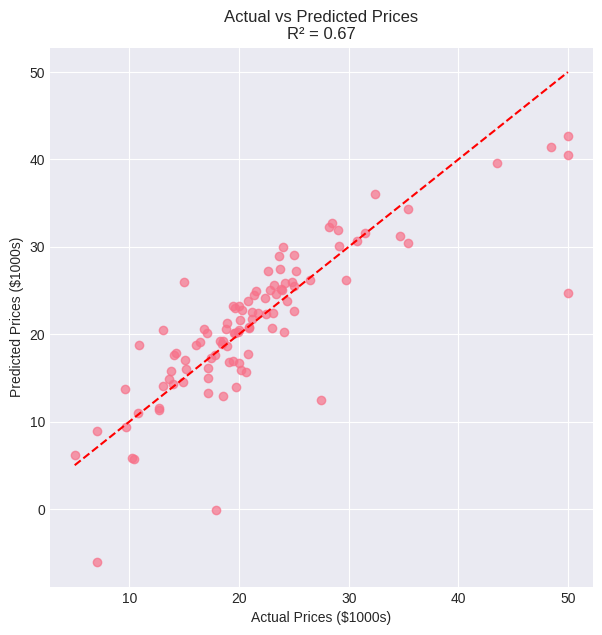

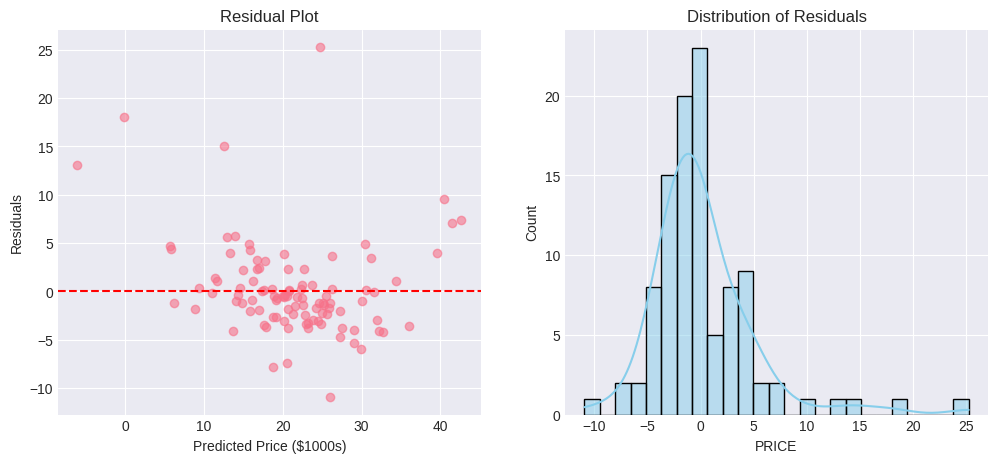


Mean Residual: 0.236
Residual Std Dev: 4.947


In [ ]:
# -------------------------------------------------------------------
# Step 9: Model Evaluation
# -------------------------------------------------------------------
# Ensure X_test has numeric dtypes
X_test = X_test.apply(pd.to_numeric, errors='coerce')
y_pred = model.predict(X_test)
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print("\n=== Model Performance ===")
print(f"R²: {r2:.3f}")
print(f"MAE: {mae:.3f} ($1000s)")
print(f"RMSE: {rmse:.3f} ($1000s)")

# -------------------------------------------------------------------
# Step 10: Actual vs Predicted Prices Plot
# -------------------------------------------------------------------
plt.figure(figsize=(7,7))
plt.scatter(y_test, y_pred, alpha=0.7)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Actual Prices ($1000s)')
plt.ylabel('Predicted Prices ($1000s)')
plt.title(f'Actual vs Predicted Prices\nR² = {r2:.2f}')
plt.show()

# -------------------------------------------------------------------
# Step 11: Residual Analysis
# -------------------------------------------------------------------
residuals = y_test - y_pred
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.scatter(y_pred, residuals, alpha=0.6)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted Price ($1000s)')
plt.ylabel('Residuals')
plt.title('Residual Plot')

plt.subplot(1,2,2)
sns.histplot(residuals, kde=True, color='skyblue', bins=25)
plt.title('Distribution of Residuals')
plt.show()

print(f"\nMean Residual: {residuals.mean():.3f}")
print(f"Residual Std Dev: {residuals.std():.3f}")

In [ ]:
# -------------------------------------------------------------------
# Step 12: Predict a New Property
# -------------------------------------------------------------------
sample_property = pd.DataFrame({
    'CRIM': [0.05],
    'ZN': [20.0],
    'INDUS': [5.0],
    'CHAS': [0],
    'NOX': [0.45],
    'RM': [7.0],
    'AGE': [40.0],
    'DIS': [5.0],
    'RAD': [4],
    'TAX': [300],
    'PTRATIO': [16.0],
    'B': [390.0],
    'LSTAT': [8.0]
})

pred_price = model.predict(sample_property)[0]
print(f"\nPredicted Price for Sample Property: ${pred_price*1000:.2f}")


Predicted Price for Sample Property: $30841.52


## **Summary - Hedonic Pricing Model (1974)**

### Key Insights:

**Most Valuable Feature:** Median Income
- Strongest predictor of house value
- Neighborhood quality matters!

**Age Effect:** Varies by feature
- Some areas value historic properties
- Others prefer newer construction

**Model Strengths:**
- Fully interpretable (we understand every coefficient)
- Fast computation (instant predictions)
- Transparent decision-making

**Model Weaknesses:**
- Linear assumption too simplistic
- Misses complex patterns
- ~33% of variation unexplained


### **References**

**Primary Source:**
```
Rosen, S. (1974). "Hedonic Prices and Implicit Markets: Product
Differentiation in Pure Competition," Journal of Political Economy,
Vol. 82, No. 1, pp. 34-55.

DOI: https://doi.org/10.1086/260169
Citations: 10,000+
```

**Dataset:**
```
California Housing Dataset
Source: Scikit-learn built-in datasets
Based on: 1990 California census data
Features: 8 property/neighborhood characteristics
Observations: 20,640 block groups
```

**Implementation:**
```
Method: Ordinary Least Squares (OLS) Linear Regression
Library: Scikit-learn (LinearRegression)
